In [1]:
#!/usr/bin/env python
# encoding: utf-8

# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import importlib
import math
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import csv_decoder
# import save_and_load
# import substructure

In [2]:
def return_image_list(event_list, width=40, height=40):
    image_list = []
    image_0 = np.zeros((width,height)) #Charged pt #FRANK# I think it's labeled wrong here. Would it matter?
    image_1 = np.zeros((width,height)) #Neutral pt
    image_2 = np.zeros((width,height)) #Charged multiplicity
    
    #FRANK# pt, eta, phi, m, id, isCharged \n
    #FRANK# 0   1	2	3  4   5
    for z in range(len(event_list)):
        image_0 = np.zeros((width,height));image_1 = np.zeros((width,height));image_2 = np.zeros((width,height))
        for x in range(len(event_list[z])):
#             if event_list[z][x,2] < -math.pi:
#                 event_list[z][x,2] = event_list[z][x,2] + math.pi
                
            phi_index = math.floor(width*event_list[z][x,2]//(2*math.pi)+width//2)
            eta_index = math.floor(height*event_list[z][x,1]//10+height/2) #FRANK# // is integer divide
            eta_index = min(eta_index,height-1)
            eta_index = max(0,eta_index)
            phi_index = int(phi_index);eta_index = int(eta_index)
            if (event_list[z][x,5] == 0):  #FRANK# neutral
                image_0[phi_index,eta_index] = image_0[phi_index,eta_index] + event_list[z][x,0]
            elif (event_list[z][x,5] == 1):  #FRANK# charged
                image_1[phi_index,eta_index] = image_1[phi_index,eta_index] + event_list[z][x,0]
                image_2[phi_index,eta_index] = image_2[phi_index,eta_index] + 1
        image_0 = np.divide(image_0,np.sum(image_0))
        image_1 = np.divide(image_1,np.sum(image_1))
        image_2 = np.divide(image_2,np.sum(image_2))
        image_list.append(np.array([image_0,image_1,image_2]))
    return np.array(image_list)
def zero_center_and_normalize(image_lists):
	tmp_av = np.average(np.concatenate(image_lists), axis=0)
	tmp_sd = np.std(np.concatenate(image_lists), axis=0)
	for j in range(len(image_lists)):
		for i in range(len(image_lists[j])):
			image_lists[j][i] = np.divide((image_lists[j][i] - tmp_av), (tmp_sd+1e-5)) #perhaps add some r to temp_sd to suppress noise
	return np.array(image_lists)

def Rotate_Event_List(event_list,higgs_list):
    #pt, eta, phi, m, id, isCharged
    event_list_rotated = copy.deepcopy(event_list)

    for i in range(len(event_list_rotated)):
        event_list_rotated[i][:,2] = event_list_rotated[i][:,2] + np.pi/2 - higgs_list[i,2]
        for j in range(len(event_list_rotated[i][:,2])):
            if event_list_rotated[i][j,2] > np.pi:
                event_list_rotated[i][j,2] = event_list_rotated[i][j,2] - 2*np.pi

        # flip Eta(Higgs )
        if higgs_list[i,1] < 0:
            event_list_rotated[i][:,1] = -1*event_list_rotated[i][:,1]
            
    return np.array(event_list_rotated)

In [3]:
file_path = "numpy_file_4"

ggh_event_list = np.load("./"+file_path+"/ggH_event_list.npy", allow_pickle=True)
ggh_higgs_list = np.load("./"+file_path+"/ggH_higgs.npy", allow_pickle=True)
vbf_event_list = np.load("./"+file_path+"/VBF_event_list.npy", allow_pickle=True)
vbf_higgs_list = np.load("./"+file_path+"/VBF_higgs.npy", allow_pickle=True)
vh_event_list = np.load("./"+file_path+"/VH_event_list.npy", allow_pickle=True)
vh_higgs_list = np.load("./"+file_path+"/VH_higgs.npy", allow_pickle=True)
tth_event_list = np.load("./"+file_path+"/ttH_event_list.npy", allow_pickle=True)
tth_higgs_list = np.load("./"+file_path+"/ttH_higgs.npy", allow_pickle=True)


In [4]:
path_test = "./BDT_Model_for_test/"
pre_2CNN = np.load("./2CNN_pre_rotated.npy")
Data_test = pd.read_csv(path_test + "Data_train.csv")

Data_test["2CNN_out1"],Data_test["2CNN_out2"],Data_test["2CNN_out3"],Data_test["2CNN_out4"] = pre_2CNN[:,0],pre_2CNN[:,1],pre_2CNN[:,2],pre_2CNN[:,3]
Data_test["PTH"] = Data_test["higgs_pt"]

axis = "2CNN_out1"
CNN_th = 0.0
ptlow, pthigh = 0, 100000
ggH_test = Data_test[(Data_test["isGGH"]==1) & (Data_test[axis] >= CNN_th) & (Data_test["PTH"] >= ptlow)& (Data_test["PTH"] <= pthigh)]
VBF_test = Data_test[(Data_test["isVBF"]==1) & (Data_test[axis] >= CNN_th) & (Data_test["PTH"] >= ptlow)& (Data_test["PTH"] <= pthigh)]
VH_test = Data_test[(Data_test["isVH"]==1) & (Data_test[axis] >= CNN_th) & (Data_test["PTH"] >= ptlow)& (Data_test["PTH"] <= pthigh)]
ttH_test = Data_test[(Data_test["isttH"]==1) & (Data_test[axis] >= CNN_th)& (Data_test["PTH"] >= ptlow)& (Data_test["PTH"] <= pthigh)] 

print(len(ggH_test),len(VBF_test),len(VH_test),len(ttH_test))



229000 229000 229000 229000


### Event Image: $\phi$ [-$\pi$,$\pi$] $\to$ [0,40]

In [5]:
N = 1000
hj_image_list = return_image_list(ggh_event_list[ggH_test["eventindex"]][:N], width=40, height=40)
vbf_image_list = return_image_list(vbf_event_list[VBF_test["eventindex"]][:N], width=40, height=40)
vh_image_list = return_image_list(vh_event_list[VH_test["eventindex"]][:N], width=40, height=40)
tth_image_list = return_image_list(tth_event_list[ttH_test["eventindex"]][:N], width=40, height=40)

# hj_image_list, vbf_image_list, vh_image_list, tth_image_list = zero_center_and_normalize((hj_image_list,vbf_image_list,vh_image_list,tth_image_list))
# vbf_image_list = zero_center_and_normalize(vbf_image_list)

hj_image_list_rotated = return_image_list(Rotate_Event_List(ggh_event_list[ggH_test["eventindex"]][:N],ggh_higgs_list[ggH_test["eventindex"]]), width=40, height=40)
vbf_image_list_rotated = return_image_list(Rotate_Event_List(vbf_event_list[VBF_test["eventindex"]][:N],vbf_higgs_list[VBF_test["eventindex"]]), width=40, height=40)
vh_image_list_rotated = return_image_list(Rotate_Event_List(vh_event_list[VH_test["eventindex"]][:N],vh_higgs_list[VH_test["eventindex"]]), width=40, height=40)
tth_image_list_rotated = return_image_list(Rotate_Event_List(tth_event_list[ttH_test["eventindex"]][:N],tth_higgs_list[ttH_test["eventindex"]]), width=40, height=40)

# hj_image_list_rotated, vbf_image_list_rotated, vh_image_list_rotated, tth_image_list_rotated = zero_center_and_normalize((hj_image_list_rotated, vbf_image_list_rotated, vh_image_list_rotated, tth_image_list_rotated))
# vbf_image_list_rotated = zero_center_and_normalize(vbf_image_list_rotated)

print("# of GGH",len(hj_image_list))
print("# of VBF",len(vbf_image_list))
print("# of VH",len(vh_image_list))
print("# of ttH",len(tth_image_list))

hj_image_list = sum(hj_image_list)/len(hj_image_list)
vbf_image_list = sum(vbf_image_list)/len(vbf_image_list)
vh_image_list = sum(vh_image_list)/len(vh_image_list)
tth_image_list = sum(tth_image_list)/len(tth_image_list)
hj_image_list_rotated = sum(hj_image_list_rotated)/len(hj_image_list_rotated)
vbf_image_list_rotated = sum(vbf_image_list_rotated)/len(vbf_image_list_rotated)
vh_image_list_rotated = sum(vh_image_list_rotated)/len(vh_image_list_rotated)
tth_image_list_rotated = sum(tth_image_list_rotated)/len(tth_image_list_rotated)

EVENT_original = [hj_image_list,vbf_image_list,vh_image_list,tth_image_list]
EVENT_rotated = [hj_image_list_rotated,vbf_image_list_rotated,vh_image_list_rotated,tth_image_list_rotated]

# of GGH 1000
# of VBF 1000
# of VH 1000
# of ttH 1000


Rotated
ggF event image:


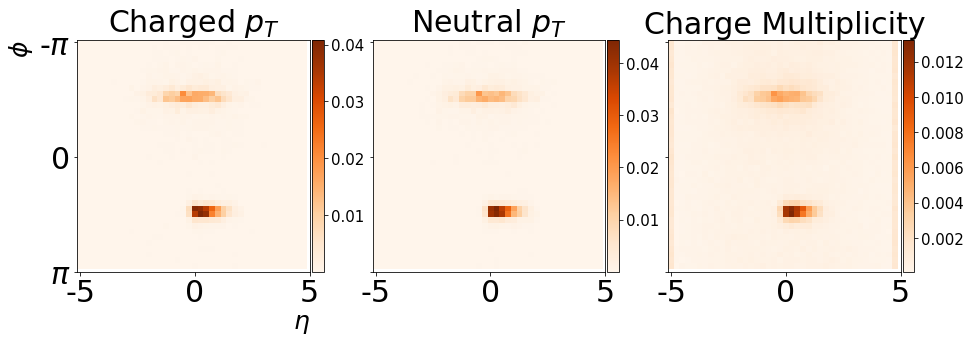

VBF event image:


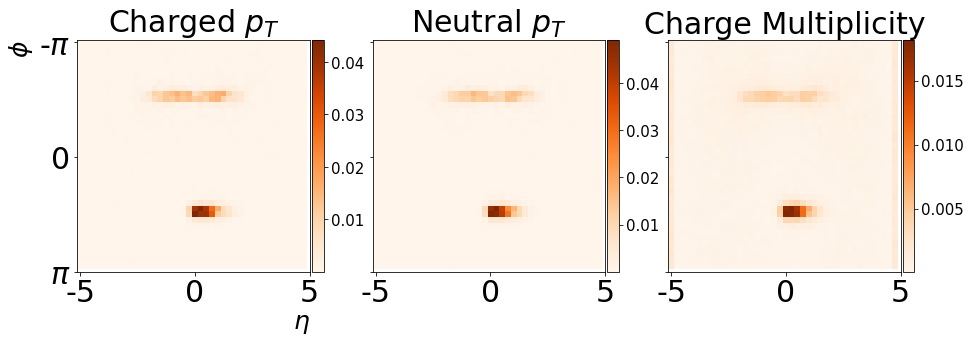

VH event image:


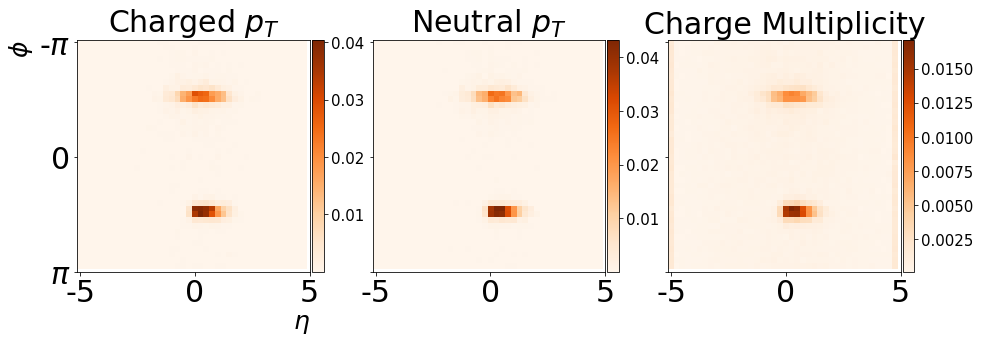

ttH event image:


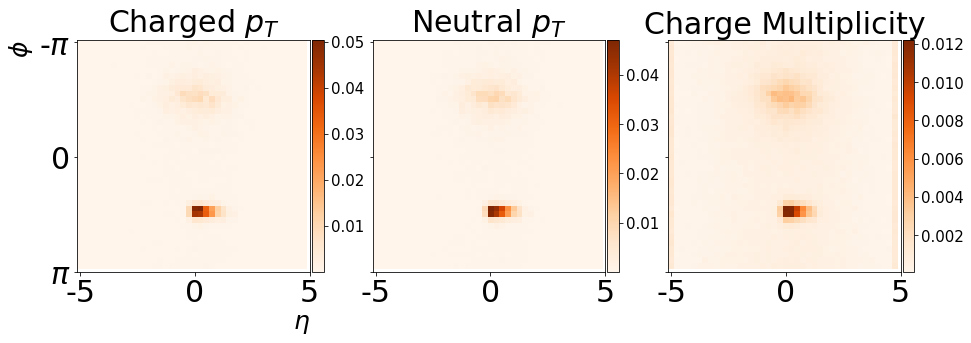

In [6]:
# Event image
name_list = ["ggF","VBF","VH","ttH"]
# name_list = ["ggF"]
figtitle = ["Charged $p_T$", "Neutral $p_T$", "Charge Multiplicity"]

if axis == "2CNN_out1":
    k = 0
elif axis == "2CNN_out2":
    k = 1
elif axis == "2CNN_out3":
    k = 2
elif axis == "2CNN_out4":
    k = 3  



# for i, element in enumerate(name_list): 
#     print("Original")
#     print( element + ' event image:')
#     fig, ax = plt.subplots(1,1, figsize=(15,5))
#     for j in range(1,4):
#         plt.subplot(1,3,j)
#         cs = ax.imshow(EVENT_original[i][j-1],cmap="Oranges")        
#         plt.imshow(EVENT_original[i][j-1],cmap="Oranges")
#         plt.title(figtitle[j-1],fontsize=20)
#         cb = plt.colorbar(cs)

#         plt.xticks([0,20,40],["-5","0","5"], fontsize=15, rotation=0)
#         plt.yticks([0,20,40],["-$\pi$","0","$\pi$"], fontsize=15)
# #         plt.tick_params(labelbottom=False,labelleft=False,bottom=0,left=0) 
        
#         plt.ylabel("$\phi$", fontsize=25,horizontalalignment='right',y=1)
#         plt.xlabel("$\eta$", fontsize=25,horizontalalignment='right',x=1)
        
# #         cb.ax.tick_params(labelsize=10)
# #         plt.savefig("./Plot/"+name_list[k]+"_/event_image_"+str(name_list[i])+".pdf", transparent=True)
# #         plt.savefig("./Plot/event_image_"+str(name_list[i])+".pdf", transparent=True)
#     plt.show()
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Rotated")
for i, element in enumerate(name_list): 
    print( element + ' event image:')
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    for j in range(1,4):
        ax2 = plt.subplot(1,3,j)
        aa = ax2.imshow(EVENT_rotated[i][j-1],cmap="Oranges")
        plt.title(figtitle[j-1],fontsize=30)

        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad="1%")
        cbar = plt.colorbar(aa, cax=cax)
        cbar.ax.tick_params(labelsize=15)
        
#         plt.xticks([0,20,40],["-5","0","5"], fontsize=15, rotation=0)
#         plt.yticks([0,20,40], fontsize=15)
        ax2.set_xticks([0,20,40])
        ax2.set_xticklabels(["-5","0","5"], fontsize=30, rotation=0)
        
                
        ax2.set_yticks([0,20,40])
        ax2.set_yticklabels(["","",""], fontsize=30, rotation=0)
        
        if j == 1:
            ax2.set_yticks([0,20,40])
            ax2.set_yticklabels(["-$\pi$","0","$\pi$"], fontsize=30, rotation=0)
            ax2.set_ylabel("$\phi$", fontsize=25,horizontalalignment='right',y=1)
            ax2.set_xlabel("$\eta$", fontsize=25,horizontalalignment='right',x=1)

        
#         plt.savefig("./Plot/"+name_list[k]+"_/event_image_"+str(name_list[i])+"_rotated.pdf", transparent=True)
        plt.savefig("./Plot/event_image_"+str(name_list[i])+"_rotated.pdf", transparent=True)
    plt.show()

# Jet Images

In [7]:
# path_test = "./BDT_Model_for_test/"
# pre_2CNN = np.load("./2CNN_pre.npy")
# Data_test = pd.read_csv(path_test + "Data_train.csv")

# Data_test["2CNN_out1"],Data_test["2CNN_out2"],Data_test["2CNN_out3"],Data_test["2CNN_out4"] = pre_2CNN[:,0],pre_2CNN[:,1],pre_2CNN[:,2],pre_2CNN[:,3]
# Data_test["PTH"] = Data_test["higgs_pt"]

# axis = "2CNN_out1"
# CNN_th = 0.9

# ggH_test = Data_test[(Data_test["isGGH"]==1) & (Data_test[axis] >= CNN_th)]
# VBF_test = Data_test[(Data_test["isVBF"]==1) & (Data_test[axis] >= CNN_th)]
# VH_test = Data_test[(Data_test["isVH"]==1) & (Data_test[axis] >= CNN_th)]
# ttH_test = Data_test[(Data_test["isttH"]==1) & (Data_test[axis] >= CNN_th)]

# print(min(len(ggH_test),len(VBF_test),len(VH_test),len(ttH_test)))

In [8]:
N = 1000
width, height = 40, 40
print("Jet Clustering")
ggh_clustered = csv_decoder.cluster_event(ggh_event_list[ggH_test["eventindex"]][:N])
vbf_clustered = csv_decoder.cluster_event(vbf_event_list[VBF_test["eventindex"]][:N])
vh_clustered = csv_decoder.cluster_event(vh_event_list[VH_test["eventindex"]][:N])
tth_clustered = csv_decoder.cluster_event(tth_event_list[ttH_test["eventindex"]][:N])

ggh_non_higgs_jets, ggh_non_higgs_fat_jets, ggh_higgs_jet, ggh_higgs_fat_jet, ggh_non_higgs_jet_list = csv_decoder.recluster_event(ggh_clustered, ggh_higgs_list[ggH_test["eventindex"]][:N])
vbf_non_higgs_jets, vbf_non_higgs_fat_jets, vbf_higgs_jet, vbf_higgs_fat_jet, vbf_non_higgs_jet_list = csv_decoder.recluster_event(vbf_clustered, vbf_higgs_list[VBF_test["eventindex"]][:N])
vh_non_higgs_jets, vh_non_higgs_fat_jets, vh_higgs_jet, vh_higgs_fat_jet, vh_non_higgs_jet_list = csv_decoder.recluster_event(vh_clustered, vh_higgs_list[VH_test["eventindex"]][:N])
tth_non_higgs_jets, tth_non_higgs_fat_jets, tth_higgs_jet, ttH_higgs_fat_jet, tth_non_higgs_jet_list = csv_decoder.recluster_event(tth_clustered, tth_higgs_list[ttH_test["eventindex"]][:N])

print("# of GGH",len(ggh_clustered))
print("# of VBF",len(vbf_clustered))
print("# of VH",len(vh_clustered))
print("# of ttH",len(tth_clustered))



# Produce jet images
print('Producing jet images')
ggh_recluster_images = csv_decoder.return_jet_image_list(ggh_event_list[ggH_test["eventindex"]][:N],ggh_non_higgs_jets,0.8, width=width, height=height)
vbf_recluster_images = csv_decoder.return_jet_image_list(vbf_event_list[VBF_test["eventindex"]][:N],vbf_non_higgs_jets,0.8, width=width, height=height)
vh_recluster_images = csv_decoder.return_jet_image_list(vh_event_list[VH_test["eventindex"]][:N],vh_non_higgs_jets,0.8, width=width, height=height)
tth_recluster_images = csv_decoder.return_jet_image_list(tth_event_list[ttH_test["eventindex"]][:N],tth_non_higgs_jets,0.8, width=width, height=height)

ggh_recluster_images = sum(ggh_recluster_images)/len(ggh_recluster_images)
vbf_recluster_images = sum(vbf_recluster_images)/len(vbf_recluster_images)
vh_recluster_images = sum(vh_recluster_images)/len(vh_recluster_images)
tth_recluster_images = sum(tth_recluster_images)/len(tth_recluster_images)

JET = [ggh_recluster_images,vbf_recluster_images,vh_recluster_images,tth_recluster_images]

Jet Clustering
# of GGH 1000
# of VBF 1000
# of VH 1000
# of ttH 1000
Producing jet images
Number of events with only one constituent in leading jet: 1
Number of events with only one constituent in leading jet: 5
Number of events with only one constituent in leading jet: 41
Number of events with only one constituent in leading jet: 1


ggF jet image:


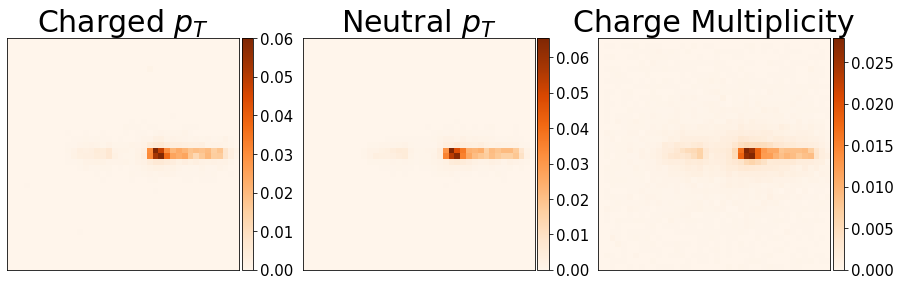

VBF jet image:


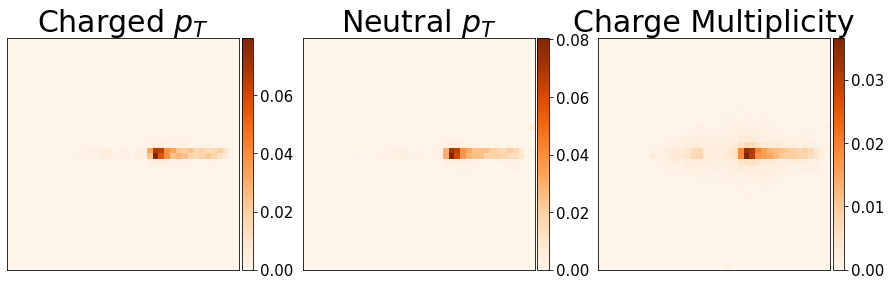

VH jet image:


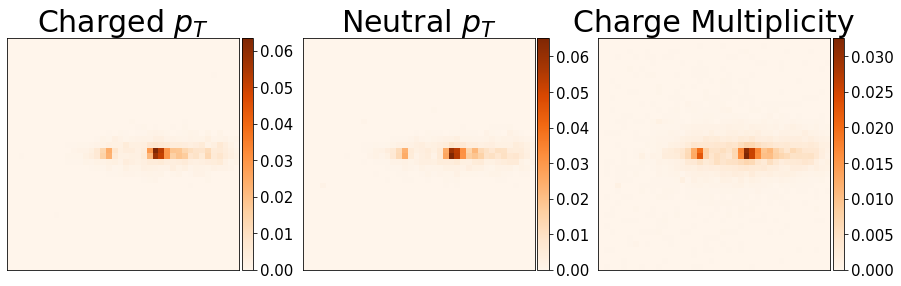

ttH jet image:


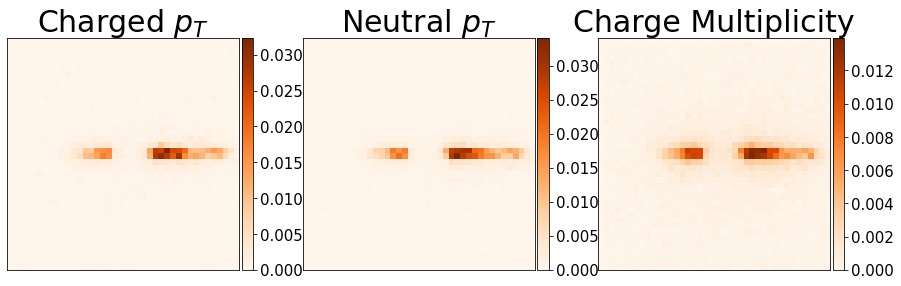

In [9]:
# Jet image
name_list = ["ggF","VBF","VH","ttH"]
figtitle = ["Charged $p_T$", "Neutral $p_T$", "Charge Multiplicity"]

if axis == "2CNN_out1":
    k = 0
elif axis == "2CNN_out2":
    k = 1
elif axis == "2CNN_out3":
    k = 2
elif axis == "2CNN_out4":
    k = 3  

for i, element in enumerate(name_list): 
    print( element + ' jet image:')
    plt.figure(figsize=(15,5))

    for j in range(1,4):
        ax2 = plt.subplot(1,3,j)
        aa = ax2.imshow(JET[i][j-1],cmap="Oranges")
        plt.tick_params(labelbottom=False,labelleft=False,bottom=0,left=0) 
        plt.title(figtitle[j-1],fontsize=30)
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad="1%")
        cbar = plt.colorbar(aa, cax=cax)
        cbar.ax.tick_params(labelsize=15)
        
        # cb.ax.tick_params(labelsize=10)
#     plt.savefig("./Plot/"+name_list[k]+"_1000/jet_image_"+str(name_list[i])+".pdf", transparent=True)
    plt.savefig("./Plot/jet_image_"+str(name_list[i])+".pdf", transparent=True)
    plt.show() 